In [1]:
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline
import numpy as np
# 
from object_detection.utils import visualization_utils as vis_util

/mnt/e/SW_WS/Python_SW/voice-camera/object_detection/utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/pyt

In [2]:
from image_processor import ImageProcessor
detect = ImageProcessor()
detect.setup()

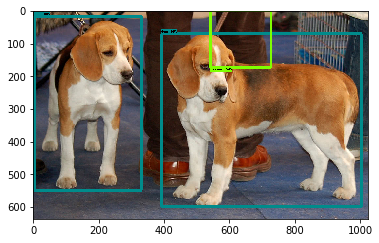

In [4]:
TEST_IMAGE_PATH = 'data/image1.jpg'
img = detect.load_image_into_numpy_array(TEST_IMAGE_PATH)
# plt.imshow(img)
(boxes, scores, classes, num) = detect.detect(img)
# Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
  img,
  np.squeeze(boxes),
  np.squeeze(classes).astype(np.int32),
  np.squeeze(scores),
  detect.labels,
  use_normalized_coordinates=True,
  line_thickness=8)
plt.figure()
plt.imshow(img)

In [5]:
from drawing_dataset import DrawingDataset
dataset = DrawingDataset('./data/quick_draw_pickles/', './data/label_mapping.jsonl')
dataset.setup()

In [6]:
from sketch import SketchGizeh


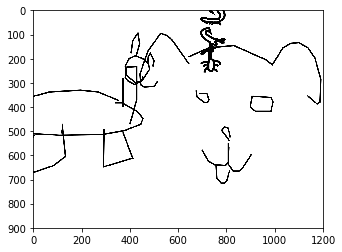

In [8]:
sk = SketchGizeh()
sk.setup()
sk.draw_object_recognition_results(np.squeeze(boxes),
                                   np.squeeze(classes).astype(np.int32),
                                   np.squeeze(scores),
                                   detect.labels,
                                   dataset)
plt.imshow(sk.get_npimage())

In [9]:
sk.save_png('data/paint.png')

## Extract only the first 100 quick drawings from each class

This is a special version of DrawingDataset class used to extract 100 binary drawings from bin files.
**Do not use it in the app.**

In [1]:
import six.moves.urllib as urllib
import struct
from struct import unpack
from pathlib import Path
import logging
# import click
import json


class DrawingDatasetX(object):
    """
    interface to the drawing dataset
    """

    def __init__(self, path_to_drawing_dataset, path_to_label_mapping):
        self._path = Path(path_to_drawing_dataset)
        self._categories_filepath = self._path / 'categories.txt'
        self._category_mapping_filepath = path_to_label_mapping
        self._quickdraw_dataset_url = 'https://storage.googleapis.com/quickdraw_dataset/full/binary/'
        self._categories = []
        self._category_mapping = dict()
        self._logger = logging.getLogger(self.__class__.__name__)

    def setup(self):
        try:
            with open(self._category_mapping_filepath, encoding='utf-8') as data_file:
                 self._category_mapping = json.loads(data_file.read())
            # with jsonlines.open(self._category_mapping_filepath, mode='r') as reader:
            #     self._category_mapping = reader.read()
        except IOError as e:
            self._logger.exception(e)
            print('label_mapping.jsonl not found')
            raise e
        self._categories = self.load_categories(self._path)
        if not self._categories:
            self.download_recurse(self._quickdraw_dataset_url, self._path)
            self._categories = self.load_categories(self._path)

    def download(self, url, filename, path):
        """download file @ specified url and save it to path
        """
        if not Path(path).exists():
            Path(path).mkdir()
        fpath = Path(path) / filename
        opener = urllib.request.URLopener()
        opener.retrieve(url, str(fpath))
        return fpath

    def download_recurse(self, url, path):
        """download all available files from url
        """
        path = Path(path)
        with open(str(self._categories_filepath)) as f:
            categories = f.readlines()
        categories = [cat.strip() for cat in categories]
        for cat in categories:
            site = url + cat.replace(' ', '%20') + '.bin'
            fpath = self.download(site, cat + '.bin', path)
            print('downloaded: {} from {}'.format(fpath, site))

    def load_categories(self, path):
        files = Path(path).glob('*.bin')
        categories = [f.stem for f in files]
        return categories

    def _unpack_drawing(self, file_handle):
        """unpack single drawing from google draw dataset binary files
        """
        key_id, = unpack('Q', file_handle.read(8))
        countrycode, = unpack('2s', file_handle.read(2))
        recognized, = unpack('b', file_handle.read(1))
        timestamp, = unpack('I', file_handle.read(4))
        n_strokes, = unpack('H', file_handle.read(2))
        image = []
        for i in range(n_strokes):
            n_points, = unpack('H', file_handle.read(2))
            fmt = str(n_points) + 'B'
            x = unpack(fmt, file_handle.read(n_points))
            y = unpack(fmt, file_handle.read(n_points))
            image.append((x, y))

        return {
            'key_id': key_id,
            'countrycode': countrycode,
            'recognized': recognized,
            'timestamp': timestamp,
            'image': image
        }

    def unpack_drawings(self, path):
        """read all drawings from binary file, and return a generator
        """
        with open(path, 'rb') as f:
            while True:
                try:
                    yield self._unpack_drawing(f)
                except struct.error:
                    break

    def get_drawing(self, name, index):
        """get a drawing by name and index, e.g. 100th 'pelican'
        """
        try:
            if name not in self._categories:
                # try and get the closest matching drawing. If nothing suitable foumd then return a scorpion
                name = self._category_mapping.get(name, 'scorpion')
            if index < 1 or not isinstance(index, int):
                raise ValueError('index must be integer > 0')
            itr = self.unpack_drawings(str(self._path / Path(name).with_suffix('.bin')))
            for i in range(index):
                drawing = next(itr)
            return drawing['image']
        except ValueError as e:
            self.log.exception(e)
            raise e

    def get_drawings(self, name, count):
        """get a drawings by name and count, e.g. 100 'cat's
        """
        try:
            if name not in self._categories:
                # try and get the closest matching drawing. If nothing suitable foumd then return a scorpion
                name = self._category_mapping.get(name, 'scorpion')
            if count < 1 or not isinstance(count, int):
                raise ValueError('index must be integer > 0')
            itr = self.unpack_drawings(str(self._path / Path(name).with_suffix('.bin')))
            drawings = []
            for i in range(count):
                drawing = next(itr)
                drawings.append(drawing['image'])
            return drawings
        except ValueError as e:
            self.log.exception(e)
            raise e
    @property
    def categories(self):
        return self._categories

    

from os import listdir
from os.path import isfile, join
import pickle
import os
from os.path import basename

pickle_dir = './data/quick_draw_pickles/'
bin_dir = './data/quick_draw_bins/'
os.makedirs(pickle_dir, exist_ok=True)

dataset = DrawingDatasetX(bin_dir, './data/label_mapping.jsonl')
dataset.setup()

binFiles = [join(bin_dir, f) for f in listdir(bin_dir) if isfile(join(bin_dir, f)) and f.endswith('bin')]
for binFile in binFiles:
    baseName = basename(os.path.splitext(binFile)[0])
    pickleFile = join(pickle_dir, baseName+'.p')
    print(pickleFile)
    images = dataset.get_drawings(baseName,100)
    with open(pickleFile,"wb") as f:
        pickle.dump(images, f)

./data/quick_draw_pickles/airplane.p
./data/quick_draw_pickles/apple.p
./data/quick_draw_pickles/backpack.p
./data/quick_draw_pickles/banana.p
./data/quick_draw_pickles/baseball bat.p
./data/quick_draw_pickles/baseball.p
./data/quick_draw_pickles/cat.p
./data/quick_draw_pickles/dog.p
./data/quick_draw_pickles/donut.p
./data/quick_draw_pickles/face.p
./data/quick_draw_pickles/pants.p
./data/quick_draw_pickles/smiley face.p
./data/quick_draw_pickles/t-shirt.p
